In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import norm
from gp_dev.core import *
from ddop.datasets import load_yaz
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df = load_yaz(encode_date_features=True, include_prod=['STEAK']).frame

In [3]:
df.columns

Index(['ISHOLIDAY', 'WEEKEND', 'WIND', 'CLOUDS', 'RAINFALL',
       'HOURS_OF_SUNSHINE', 'TEMPERATURE', 'WEEKDAY_FRI', 'WEEKDAY_MON',
       'WEEKDAY_SAT', 'WEEKDAY_SUN', 'WEEKDAY_THU', 'WEEKDAY_TUE',
       'WEEKDAY_WED', 'MONTH_APR', 'MONTH_AUG', 'MONTH_DEC', 'MONTH_FEB',
       'MONTH_JAN', 'MONTH_JUL', 'MONTH_JUN', 'MONTH_MAR', 'MONTH_MAY',
       'MONTH_NOV', 'MONTH_OCT', 'MONTH_SEP', 'YEAR_2013', 'YEAR_2014',
       'YEAR_2015', 'STEAK'],
      dtype='object')

In [4]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=1, ard_num_dims=24)
        #self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def nv_cost(q, y, cu, co):
    if q>y:
        cost = (q-y)*co
    else:
        cost = (y-q)*cu
    return cost


In [5]:
res = []

In [6]:
for target in ['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK']:
    
    df = load_yaz(encode_date_features=True, include_prod=[target]).frame
    df.drop(columns=['WIND', 'CLOUDS', 'RAINFALL',
       'HOURS_OF_SUNSHINE', 'TEMPERATURE'], inplace=True)
    
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    data = torch.tensor(df_scaled, dtype=torch.float32)
    
    N = data.shape[0]
    # make train/val/test
    #n_train = int(0.8 * N)
    n_train = 600 #
    #n_train = int(1 * N)
    train_x, train_y = data[:n_train, :-1], data[:n_train, -1]
    test_x, test_y = data[n_train:, :-1], data[n_train:, -1]
    
    # make continguous
    train_x, train_y = train_x.contiguous(), train_y.contiguous()
    test_x, test_y = test_x.contiguous(), test_y.contiguous()

    output_device = torch.device('cuda:0')

    train_x, train_y = train_x.to(output_device), train_y.to(output_device)
    test_x, test_y = test_x.to(output_device), test_y.to(output_device)

    n_devices = torch.cuda.device_count()
    print('Planning to run on {} GPUs.'.format(n_devices))
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = SpectralMixtureGPModel(train_x, train_y, likelihood).cuda()
    model.covar_module.initialize_from_data(train_x, train_y)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    training_iter = 100

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
        
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
    # See https://arxiv.org/abs/1803.06058
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Make predictions
        observed_pred = likelihood(model(test_x))
        
    y_train_unscaled = scaler.inverse_transform(df_scaled[:n_train,:])[:,-1]
    y_test_unscaled = scaler.inverse_transform(df_scaled[n_train:,:])[:,-1]
    
    n_features = df_scaled.shape[1]
    nv_means = observed_pred.mean.cpu().numpy()
    nv_means_unscaled = scaler.inverse_transform(np.stack([nv_means for i in range(n_features)], axis=1))[:,-1]

    nv_sigma = np.sqrt(torch.diag(observed_pred.covariance_matrix).cpu().detach().numpy())
    nv_sigma_unscaled = scaler.inverse_transform(np.stack([nv_sigma for i in range(n_features)], axis=1))[:,-1]
    
    for c in range(5,100, 5):
        cu = c/100
        co = 1-cu
        nv_quantile = np.quantile(y_train_unscaled, q=cu/(cu+co))
        nv_solution = nv_means_unscaled+norm.ppf(cu/(cu+co))*nv_sigma_unscaled
        cost_saa = np.mean([nv_cost(nv_quantile, y, cu, co) for y in y_test_unscaled])
        cost_gp =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, y_test_unscaled)])
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_saa, "type":"saa", "target": target})
        res.append(ser_tmp)
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_gp, "type":"gp_spectral", "target": target})
        res.append(ser_tmp)
    
df_res = pd.DataFrame(res)

Planning to run on 1 GPUs.
Iter 1/100 - Loss: 0.823
Iter 2/100 - Loss: 0.775
Iter 3/100 - Loss: 0.735
Iter 4/100 - Loss: 0.700
Iter 5/100 - Loss: 0.664
Iter 6/100 - Loss: 0.623
Iter 7/100 - Loss: 0.580
Iter 8/100 - Loss: 0.538
Iter 9/100 - Loss: 0.497
Iter 10/100 - Loss: 0.458
Iter 11/100 - Loss: 0.417
Iter 12/100 - Loss: 0.373
Iter 13/100 - Loss: 0.328
Iter 14/100 - Loss: 0.284
Iter 15/100 - Loss: 0.243
Iter 16/100 - Loss: 0.200
Iter 17/100 - Loss: 0.154
Iter 18/100 - Loss: 0.109
Iter 19/100 - Loss: 0.066
Iter 20/100 - Loss: 0.023
Iter 21/100 - Loss: -0.022
Iter 22/100 - Loss: -0.066
Iter 23/100 - Loss: -0.108
Iter 24/100 - Loss: -0.151
Iter 25/100 - Loss: -0.195
Iter 26/100 - Loss: -0.236
Iter 27/100 - Loss: -0.276
Iter 28/100 - Loss: -0.317
Iter 29/100 - Loss: -0.356
Iter 30/100 - Loss: -0.394
Iter 31/100 - Loss: -0.431
Iter 32/100 - Loss: -0.466
Iter 33/100 - Loss: -0.500
Iter 34/100 - Loss: -0.532
Iter 35/100 - Loss: -0.563
Iter 36/100 - Loss: -0.590
Iter 37/100 - Loss: -0.617
Ite

In [8]:
benchmark = pd.read_csv('../res_data/gp_all-paste.csv')

In [12]:
df_res.type.unique()

array(['saa', 'gp_spectral', 'gp_spectral_no_init_mix1'], dtype=object)

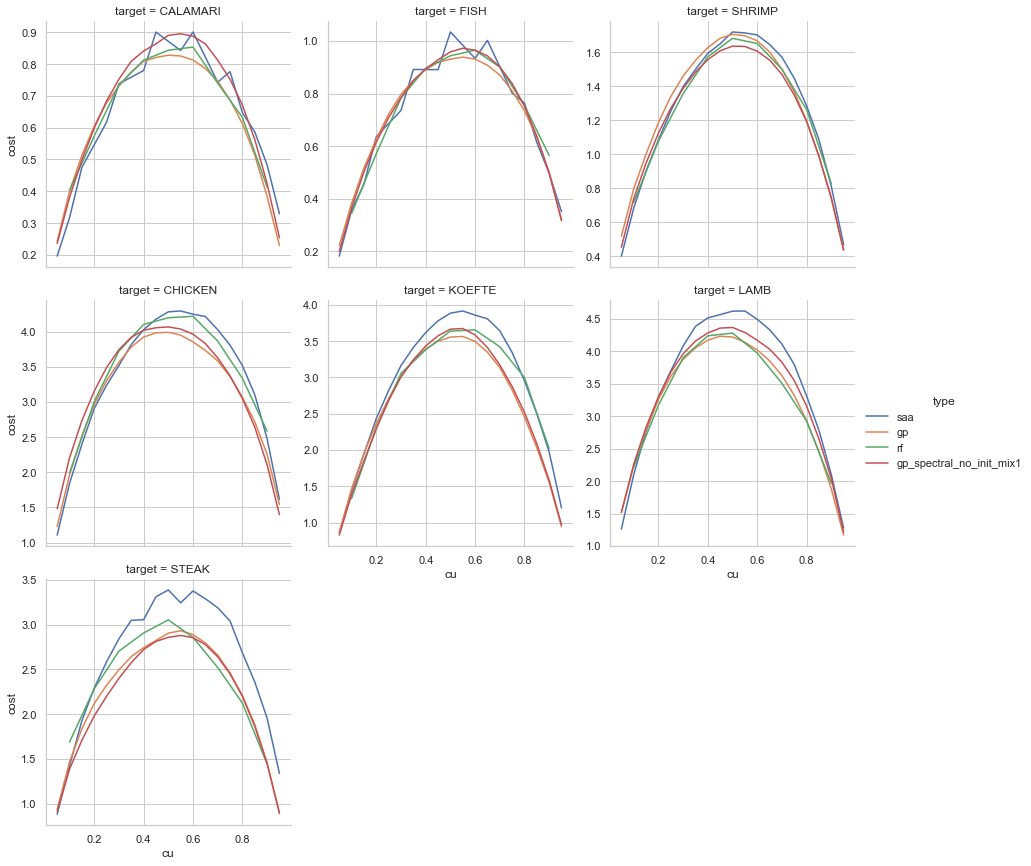

In [17]:
df_plot = pd.concat([benchmark[benchmark.type.isin(['saa','gp', 'rf'])], df_res[df_res.type.isin(['gp_spectral_no_init_mix1'])]])
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style('whitegrid')
sns.relplot(data=df_plot, x="cu", y="cost",col_wrap=3,facet_kws={'sharey':False},
    col="target", hue="type",kind="line", aspect=1, height=4); 


In [ ]:
for target in ['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK']:
    
    df = load_yaz(encode_date_features=True, include_prod=[target]).frame
    df.drop(columns=['WIND', 'CLOUDS', 'RAINFALL',
       'HOURS_OF_SUNSHINE', 'TEMPERATURE'], inplace=True)
        
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    data = torch.tensor(df_scaled, dtype=torch.float32)
    
    N = data.shape[0]
    # make train/val/test
    #n_train = int(0.8 * N)
    n_train = 600 #
    #n_train = int(1 * N)
    train_x, train_y = data[:n_train, :-1], data[:n_train, -1]
    test_x, test_y = data[n_train:, :-1], data[n_train:, -1]
    
    # make continguous
    train_x, train_y = train_x.contiguous(), train_y.contiguous()
    test_x, test_y = test_x.contiguous(), test_y.contiguous()

    output_device = torch.device('cuda:0')

    train_x, train_y = train_x.to(output_device), train_y.to(output_device)
    test_x, test_y = test_x.to(output_device), test_y.to(output_device)

    n_devices = torch.cuda.device_count()
    print('Planning to run on {} GPUs.'.format(n_devices))
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = SpectralMixtureGPModel(train_x, train_y, likelihood).cuda()
    #model.covar_module.initialize_from_data(train_x, train_y)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    training_iter = 100

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
        
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
    # See https://arxiv.org/abs/1803.06058
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Make predictions
        observed_pred = likelihood(model(test_x))
        
    y_train_unscaled = scaler.inverse_transform(df_scaled[:n_train,:])[:,-1]
    y_test_unscaled = scaler.inverse_transform(df_scaled[n_train:,:])[:,-1]
    
    n_features = df_scaled.shape[1]
    nv_means = observed_pred.mean.cpu().numpy()
    nv_means_unscaled = scaler.inverse_transform(np.stack([nv_means for i in range(n_features)], axis=1))[:,-1]

    nv_sigma = np.sqrt(torch.diag(observed_pred.covariance_matrix).cpu().detach().numpy())
    nv_sigma_unscaled = scaler.inverse_transform(np.stack([nv_sigma for i in range(n_features)], axis=1))[:,-1]
    
    for c in range(5,100, 5):
        cu = c/100
        co = 1-cu
        nv_quantile = np.quantile(y_train_unscaled, q=cu/(cu+co))
        nv_solution = nv_means_unscaled+norm.ppf(cu/(cu+co))*nv_sigma_unscaled
        #cost_saa = np.mean([nv_cost(nv_quantile, y, cu, co) for y in y_test_unscaled])
        cost_gp =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, y_test_unscaled)])
        #ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_saa, "type":"saa", "target": target})
        #res.append(ser_tmp)
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_gp, "type":"gp_spectral_no_init_mix1_2", "target": target})
        res.append(ser_tmp)
    
df_res = pd.DataFrame(res)

# Bakery data

In [18]:
df_b = pd.read_csv('../datasets/dataforprediction_V2.csv')

In [32]:
df_b_fil = df_b[(df_b.FilNr==2)&(df_b.artNr.isin([101]))]

In [33]:
df_b_fil.columns

Index(['shortDate', 'FilNr', 'artNr', 'daySalesUnit', 'sumRetour',
       'uncensoredSales', 'trueDemand', 'WGrpNr', 'currentWeek_promotionpirce',
       'currentWeek_Keine Anzeige', 'currentWeek_3+1Aktion',
       'currentWeek_2+1Aktion', 'currentWeek_info', 'lastWeek_promotionpirce',
       'lastWeek_Keine Anzeige', 'lastWeek_3+1Aktion', 'lastWeek_2+1Aktion',
       'lastWeek_info', 'dayofWeek', 'month', 'isoweek', 'State',
       'schoolholidays', 'isHolyday', 'isHolydayNext2Days', 'RSK', 'TMK',
       'TXK', 'TNK', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
       'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21',
       'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28',
       'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35',
       'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42',
       'lag_43', 'lag_44', 'lag_45', '

<AxesSubplot:xlabel='daySalesUnit', ylabel='lag_2'>

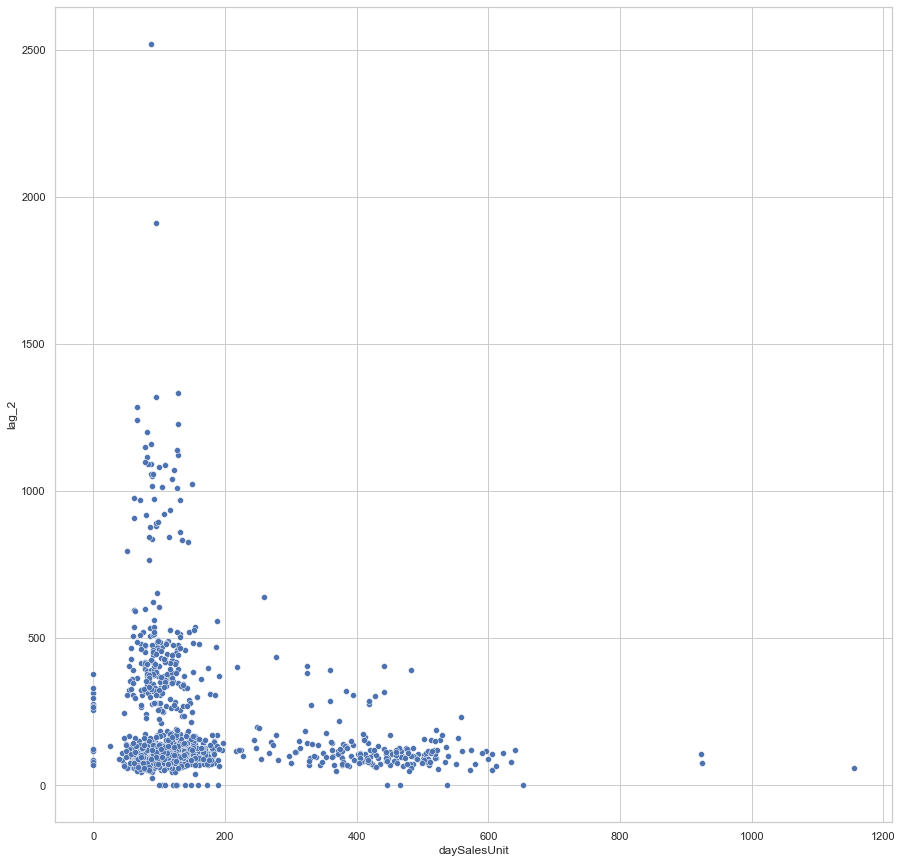

In [35]:
sns.scatterplot(x='daySalesUnit', y='lag_2', data=df_b_fil)